In [17]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras import models, layers
from tensorflow import keras
from datetime import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import json
import cv2
import os

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Num GPUs Available:  2


# Loading Data and Split Dataset 
(To Do : Lazy loading for saving memory)

In [3]:
L_data = json.load(open("700_400_Flip/Images_quarter_L/mapping.json", "r"))
R_data = json.load(open("700_400_Flip/Images_quarter_R/mapping.json", "r"))

# filter -lt 0
L_data = { k: v for k, v in L_data.items() if v >= 0 }
R_data = { k: v for k, v in R_data.items() if v >= 0 }

In [4]:
def json_2_dataframe(dataframe, data):
        classifier = lambda x : 0 if 0 <= x <=3 else 1 if 4<= x <=6 else 2
    
        for path, cal in data.items():
                item = { "Path": path[8:] , "CAL": cal, "Class": classifier(cal) }
                dataframe = dataframe.append(item, ignore_index=True)

        return dataframe

dataset = pd.DataFrame(columns=["Path", "CAL", "Class"])
dataset = json_2_dataframe(dataset, L_data)
dataset = json_2_dataframe(dataset, R_data)

# Model Training and Evaluation

In [64]:
def CNN_Model():
        model = models.Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(700, 400, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(3, activation='softmax'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        return model

In [65]:
model = CNN_Model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 698, 398, 32)      320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 349, 199, 32)      0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 347, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 173, 98, 64)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 171, 96, 128)      73856     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 85, 48, 128)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 83, 46, 128)      

In [67]:
def generate_data(dataset):
        X_train, X_test, y_train, y_test = train_test_split(dataset["Path"], dataset["Class"], test_size=0.2, random_state=1)
        X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
        def path_2_images(path_list):
                images = []
                for path in path_list:
                        image = cv2.imread(path, 0)
                        #image = cv2.resize(image, (200, 200))
                        image = np.reshape(image, (*image.shape, 1))
                        images.append(image)
                return np.array(images)
        return path_2_images(X_train), to_categorical(y_train, 3), path_2_images(X_val), to_categorical(y_val  , 3), path_2_images(X_test) , to_categorical(y_test , 3)

X_train, y_train, X_val, y_val, X_test, y_test = generate_data(dataset)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=50, batch_size=8)

Train on 1577 samples, validate on 526 samples
Epoch 1/50
1577/1577 [==============================] - 7s 4ms/step - loss: 1.0312 - accuracy: 0.6772 - val_loss: 0.7171 - val_accuracy: 0.8213
Epoch 2/50
1577/1577 [==============================] - 6s 4ms/step - loss: 0.9246 - accuracy: 0.7191 - val_loss: 0.6914 - val_accuracy: 0.8213
Epoch 3/50
1577/1577 [==============================] - 6s 4ms/step - loss: 0.8138 - accuracy: 0.7267 - val_loss: 0.6668 - val_accuracy: 0.8213
Epoch 4/50
1577/1577 [==============================] - 6s 4ms/step - loss: 0.8374 - accuracy: 0.7299 - val_loss: 0.6602 - val_accuracy: 0.8213
Epoch 5/50
1577/1577 [==============================] - 6s 4ms/step - loss: 0.7939 - accuracy: 0.7483 - val_loss: 0.6436 - val_accuracy: 0.8213
Epoch 6/50
1577/1577 [==============================] - 6s 4ms/step - loss: 0.7641 - accuracy: 0.7349 - val_loss: 0.6320 - val_accuracy: 0.8213
Epoch 7/50
1577/1577 [==============================] - 6s 4ms/step - loss: 0.7547 - accu

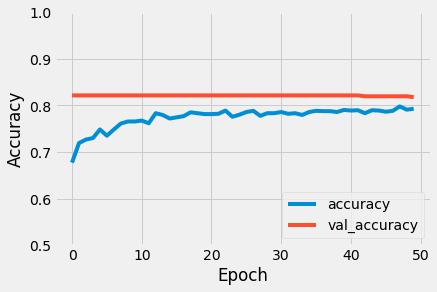

In [68]:
def plot_result(history):
        plt.style.use('fivethirtyeight')
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')
        plt.show()

plot_result(history)

In [87]:
results = model.evaluate(X_test, y_test, verbose=2, batch_size=8)
print("Test Loss = {}\nTest Acc  = {}".format(*results))
prediction = model.predict_classes(X_test, batch_size=8)
y = np.argmax(y_test, axis=1)
confusion = confusion_matrix(y, prediction)
confusion

Test Loss = 0.6414432985701035
Test Acc  = 0.7870722413063049


array([[414,   0,   0],
       [ 80,   0,   0],
       [ 32,   0,   0]])

# Resnet model

In [76]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2, ResNet50V2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.layers import Input
from keras.optimizers import SGD

In [77]:
def Resnet50():
        input_tensor = Input(shape=(700, 400, 1)) 
        base_model = ResNet50V2(input_tensor=input_tensor, weights=None, include_top=False)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(3, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [78]:
resnet_model = Resnet50()
resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 700, 400, 1)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 706, 406, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 350, 200, 64) 3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 352, 202, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [80]:
resnet_history = resnet_model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=30,batch_size=16)

Train on 1577 samples, validate on 526 samples
Epoch 1/30
1577/1577 [==============================] - 64s 40ms/step - loss: 0.6686 - accuracy: 0.7901 - val_loss: 0.7050 - val_accuracy: 0.8213
Epoch 2/30
1577/1577 [==============================] - 46s 29ms/step - loss: 0.6224 - accuracy: 0.7901 - val_loss: 0.6122 - val_accuracy: 0.8213
Epoch 3/30
1577/1577 [==============================] - 46s 29ms/step - loss: 0.6193 - accuracy: 0.7901 - val_loss: 0.5830 - val_accuracy: 0.8213
Epoch 4/30
1577/1577 [==============================] - 46s 29ms/step - loss: 0.6162 - accuracy: 0.7901 - val_loss: 0.5872 - val_accuracy: 0.8213
Epoch 5/30
1577/1577 [==============================] - 46s 29ms/step - loss: 0.6203 - accuracy: 0.7901 - val_loss: 0.5945 - val_accuracy: 0.8213
Epoch 6/30
1577/1577 [==============================] - 46s 29ms/step - loss: 0.6166 - accuracy: 0.7901 - val_loss: 0.6249 - val_accuracy: 0.8061
Epoch 7/30
1577/1577 [==============================] - 46s 29ms/step - loss:

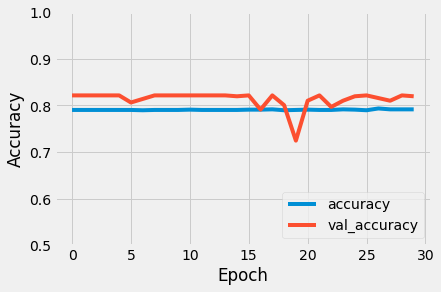

In [81]:
plot_result(resnet_history)

In [86]:
resnet_results = resnet_model.evaluate(X_test, y_test, verbose=2, batch_size=8)
print("Test Loss = {}\nTest Acc  = {}".format(*resnet_results))
resnet_prediction = resnet_model.predict(X_test, batch_size=8)
resnet_prediction = np.argmax(resnet_prediction, axis=1)
resnet_y = np.argmax(y_test, axis=1)
resnet_confusion = confusion_matrix(resnet_y, resnet_prediction)
resnet_confusion

Test Loss = 0.6303418897403964
Test Acc  = 0.7889733910560608


array([[414,   0,   0],
       [ 79,   1,   0],
       [ 32,   0,   0]])